# Install/Import needed libraries

In [1]:
sc.install_pypi_package("pandas");
sc.install_pypi_package("Matplotlib");
sc.install_pypi_package("seaborn");
sc.install_pypi_package("tqdm");
sc.install_pypi_package("s3fs");
sc.install_pypi_package("scikit-learn");

VBox()

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/94/b1/f77f49cc7cc538b247f30c2ae7e3a50f29e44f0b1af32ff4869d7de3c762/pandas-1.1.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/1c/15/3fea1bfb7e5b77b7cca9c6010a9cabc58ea125385345ecb6f5832eb8b49a/matplotlib-3.3.0-1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e8/f2/6722dd0c22e3a143ac792ccb2424924ac72af4adea756b1165b4cad50da7/Pillow-7.2.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using 

In [2]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import s3fs
from sklearn import preprocessing
from sklearn.decomposition import PCA

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
bucket_file = "s3://ms-syntheamass-1m-mldata/syntheamassCSV/patient_info2/patient_info_and_observations2.csv"

sdf = spark.read.format("csv").option("inferSchema", True).option("header", False).load(bucket_file)
sdf.createOrReplaceTempView("data2")
sdf = spark.sql("""
select _c0 as patient,
_c1 as height, _c2 as weight, _c3 as BMI, _c4 as cholesterol,
_c5 as sodium, _c6 as birth_date, _c7 as marital, _c8 as race, 
_c9 as ethnicity
from data2""")
sdf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+------+-----+-----------+------+-------------------+-------+--------+---------------+
|             patient|height|weight|  BMI|cholesterol|sodium|         birth_date|marital|    race|      ethnicity|
+--------------------+------+------+-----+-----------+------+-------------------+-------+--------+---------------+
|00eec485-f89d-472...| 172.3| 94.04|31.68|      207.0| 140.0|1959-06-24 00:00:00|      M|hispanic|   puerto_rican|
|017299f2-de8f-43a...|177.38|135.75|43.15|      161.0| 139.0|1963-12-03 00:00:00|      S|   white|        italian|
|018dd53e-4b90-41c...|163.33|136.74|51.26|      162.0| 143.0|1955-11-19 00:00:00|      M|   white|          irish|
|0190ce14-8897-495...| 161.1| 72.92| 28.1|      196.0| 137.0|1939-03-17 00:00:00|      M|   white|          irish|
|01e7a88d-34ac-494...|173.35|105.97|35.27|      169.0| 143.0|1958-03-09 00:00:00|      S|   asian|        chinese|
|01f649ca-232e-4c1...|151.11|102.05|44.69|      199.0| 140.0|1965-10-17 00:00:00

# Prep for Machine Learning

## Indexing Strings

In [4]:
from pyspark.ml.feature import StringIndexer
sdf = sdf.dropna()

indexer = StringIndexer(inputCol="patient", outputCol="ID")
indexed = indexer.fit(sdf).transform(sdf)

indexer = StringIndexer(inputCol="marital", outputCol="indexed_marital")
indexed = indexer.fit(indexed).transform(indexed)

indexer = StringIndexer(inputCol="ethnicity", outputCol="indexed_ethnicity")
indexed = indexer.fit(indexed).transform(indexed)

indexer = StringIndexer(inputCol="race", outputCol="indexed_race")
indexed = indexer.fit(indexed).transform(indexed)

indexed.createOrReplaceTempView("indexed")

indexed = spark.sql("""
select ID, height, weight, BMI, sodium, birth_date, indexed_marital, indexed_ethnicity, indexed_race
from indexed
""")
indexed.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+------+-----+------+-------------------+---------------+-----------------+------------+
|     ID|height|weight|  BMI|sodium|         birth_date|indexed_marital|indexed_ethnicity|indexed_race|
+-------+------+------+-----+------+-------------------+---------------+-----------------+------------+
|12200.0| 172.3| 94.04|31.68| 140.0|1959-06-24 00:00:00|            0.0|              3.0|         1.0|
|28107.0|177.38|135.75|43.15| 139.0|1963-12-03 00:00:00|            1.0|              1.0|         0.0|
| 4998.0|163.33|136.74|51.26| 143.0|1955-11-19 00:00:00|            0.0|              0.0|         0.0|
|23024.0| 161.1| 72.92| 28.1| 137.0|1939-03-17 00:00:00|            0.0|              0.0|         0.0|
|10498.0|173.35|105.97|35.27| 143.0|1958-03-09 00:00:00|            1.0|              6.0|         3.0|
|13838.0|151.11|102.05|44.69| 140.0|1965-10-17 00:00:00|            0.0|              9.0|         0.0|
| 4376.0|169.24| 96.32|33.63| 140.0|1955-07-14 00:00:00|        

## Convert Birthday to Age

In [5]:
from datetime import datetime
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

today = datetime.today()

convert_to_age = udf(lambda birth_date: today.year - birth_date.year, IntegerType())

indexed = indexed.withColumn("age", convert_to_age(indexed.birth_date))

indexed = indexed.drop("birth_date")
indexed.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+------+-----+------+---------------+-----------------+------------+---+
|     ID|height|weight|  BMI|sodium|indexed_marital|indexed_ethnicity|indexed_race|age|
+-------+------+------+-----+------+---------------+-----------------+------------+---+
|12200.0| 172.3| 94.04|31.68| 140.0|            0.0|              3.0|         1.0| 61|
|28107.0|177.38|135.75|43.15| 139.0|            1.0|              1.0|         0.0| 57|
| 4998.0|163.33|136.74|51.26| 143.0|            0.0|              0.0|         0.0| 65|
|23024.0| 161.1| 72.92| 28.1| 137.0|            0.0|              0.0|         0.0| 81|
|10498.0|173.35|105.97|35.27| 143.0|            1.0|              6.0|         3.0| 62|
|13838.0|151.11|102.05|44.69| 140.0|            0.0|              9.0|         0.0| 55|
| 4376.0|169.24| 96.32|33.63| 140.0|            0.0|              0.0|         0.0| 65|
|24175.0|157.84| 92.49|37.13| 142.0|            1.0|              0.0|         0.0| 65|
|21366.0|185.33|109.37|31.84| 14

## Creating Feature Vectors

In [6]:
from pyspark.ml.feature import VectorAssembler
features = [feature for feature in indexed.columns if feature != "ID"]
assembler = VectorAssembler(inputCols=features, outputCol = "features")
raw_data = assembler.transform(indexed)
raw_data.select("features").show(truncate = False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------------------------+
|features                                     |
+---------------------------------------------+
|[172.3,94.04,31.68,140.0,0.0,3.0,1.0,61.0]   |
|[177.38,135.75,43.15,139.0,1.0,1.0,0.0,57.0] |
|[163.33,136.74,51.26,143.0,0.0,0.0,0.0,65.0] |
|[161.1,72.92,28.1,137.0,0.0,0.0,0.0,81.0]    |
|[173.35,105.97,35.27,143.0,1.0,6.0,3.0,62.0] |
|[151.11,102.05,44.69,140.0,0.0,9.0,0.0,55.0] |
|[169.24,96.32,33.63,140.0,0.0,0.0,0.0,65.0]  |
|[157.84,92.49,37.13,142.0,1.0,0.0,0.0,65.0]  |
|[185.33,109.37,31.84,143.0,0.0,18.0,0.0,58.0]|
|[163.33,100.15,37.54,140.0,1.0,0.0,0.0,50.0] |
|[170.46,111.64,38.42,144.0,1.0,0.0,0.0,72.0] |
|[170.45,112.29,38.65,144.0,0.0,0.0,0.0,62.0] |
|[166.01,92.5,33.56,143.0,1.0,14.0,0.0,59.0]  |
|[175.46,92.34,29.99,141.0,0.0,5.0,0.0,68.0]  |
|[173.81,108.56,35.93,139.0,1.0,12.0,2.0,71.0]|
|[162.92,102.96,38.79,143.0,0.0,1.0,0.0,66.0] |
|[166.72,76.58,27.55,139.0,0.0,0.0,0.0,38.0]  |
|[181.81,122.25,36.98,142.0,0.0,18.0,0.0

### Scaling Feature Vectors

In [7]:
from pyspark.ml.feature import StandardScaler
standardScaler=StandardScaler().setInputCol("features").setOutputCol("scaled_features")
raw_data=standardScaler.fit(raw_data).transform(raw_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
raw_data.select("scaled_features").show(5,truncate=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|     scaled_features|
+--------------------+
|[18.8109771455253...|
|[19.3655898205065...|
|[17.8316709064344...|
|[17.5882090432044...|
|[18.9256116551179...|
+--------------------+
only showing top 5 rows

# MLLib Algorithmns

#### Defining How many Cluster We Want

In [9]:
K=5

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## K-means

### Fit Data

In [10]:
from pyspark.ml.clustering import KMeans
kmeans= KMeans(featuresCol="scaled_features").setK(K).setSeed(1)
model=kmeans.fit(raw_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Predict

In [11]:
predictions = model.transform(raw_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
clusters=predictions.select("prediction")
clusters.groupby("prediction").agg({'prediction':'count'}).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         1|             8291|
|         3|             4841|
|         4|             7682|
|         2|             4518|
|         0|             4952|
+----------+-----------------+

## Hierarchical Clustering

### Fit

In [25]:
from pyspark.ml.clustering import BisectingKMeans
bkm=BisectingKMeans(featuresCol="scaled_features").setK(K).setSeed(1)
model=bkm.fit(raw_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Predict

In [26]:
predictions_b = model.transform(raw_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
cm = predictions_b.select("prediction")
cm.groupby("prediction").agg({'prediction':'count'}).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         1|             8013|
|         3|             3320|
|         4|             3649|
|         2|             7595|
|         0|             7707|
+----------+-----------------+

## Evaluation (Silhouette Score)

In [28]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator=ClusteringEvaluator()
silhouette_k=evaluator.evaluate(predictions)
silhouette_h=evaluator.evaluate(predictions_b)
print(f"""K-means silhouette with squared euclidiean distance ={str(silhouette_k)} \n
Hierachical silhouette with sqared euclidiean distance ={str(silhouette_h)}""")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

K-means silhouette with squared euclidiean distance =0.12869310057595856 

Hierachical silhouette with sqared euclidiean distance =0.15009031211834245

# PCA Visualization

## Convert Info & Cluster Labels to Pandas

In [29]:
sdff=indexed.drop("ID")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
dfp=sdff.toPandas()
dfp.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   height  weight    BMI  ...  indexed_ethnicity  indexed_race  age
0  172.30   94.04  31.68  ...                3.0           1.0   61
1  177.38  135.75  43.15  ...                1.0           0.0   57
2  163.33  136.74  51.26  ...                0.0           0.0   65
3  161.10   72.92  28.10  ...                0.0           0.0   81
4  173.35  105.97  35.27  ...                6.0           3.0   62

[5 rows x 8 columns]

In [31]:
kclust=clusters.toPandas()
hclust=cm.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Set Up PCA & Transform Info

In [32]:
pca=PCA(n_components=3)
principalComponents=pca.fit_transform(dfp)
principalDF = pd.DataFrame(data=principalComponents, columns =['Principal Component 1', 'Principal Component 2','Principal Component 3'])
principalDF.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   Principal Component 1  Principal Component 2  Principal Component 3
0               4.952620               3.238078               3.760195
1             -36.230792             -11.397124               2.296224
2             -34.416588             -17.030753             -14.730289
3              33.657774              -4.118005              -6.522622
4              -5.965688              -2.817315               2.574380

## K-Means

In [33]:
finalDFK=pd.concat([principalDF, kclust],axis=1)
#finalDFK.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
%matplot plt
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111,projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('K-Means 3 Component PCA', fontsize = 20)


targets = [0,1,2,3,4]
colors = ['r','g','b','y','m']
for target, color in zip(targets,colors):
    indicesToKeep = finalDFK['prediction'] == target
    ax.scatter(finalDFK.loc[indicesToKeep, 'Principal Component 1']
               , finalDFK.loc[indicesToKeep, 'Principal Component 2']
               , finalDFK.loc[indicesToKeep, 'Principal Component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NameError: name 'plt' is not defined

## Hierarchical

In [35]:
finalDFH=pd.concat([principalDF, hclust],axis=1)
#finalDFH.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

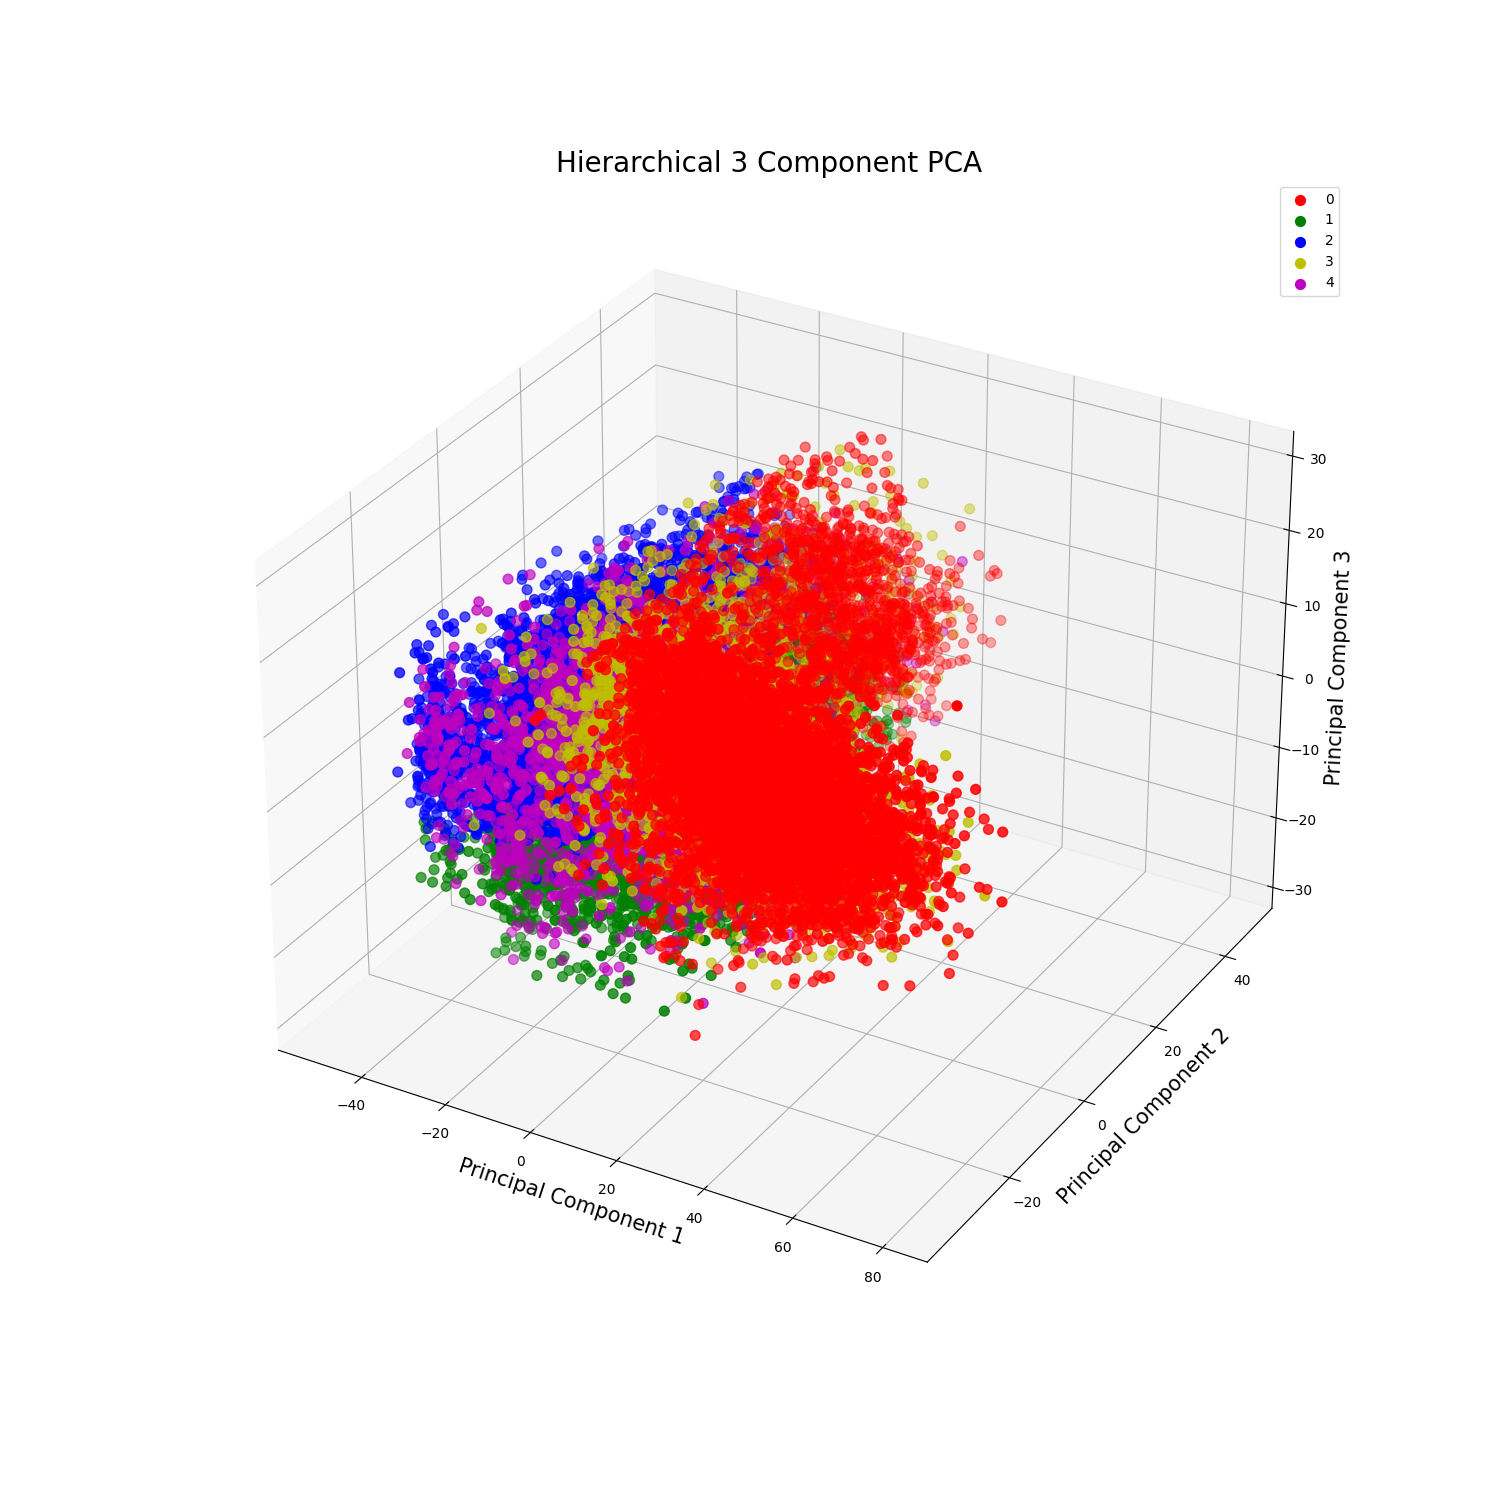

NameError: name 'plt' is not defined

In [38]:
%matplot plt
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111,projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('Hierarchical 3 Component PCA', fontsize = 20)


targets = [0,1,2,3,4]
colors = ['r','g','b','y','m']
for target, color in zip(targets,colors):
    indicesToKeep = finalDFH['prediction'] == target
    ax.scatter(finalDFH.loc[indicesToKeep, 'Principal Component 1']
               , finalDFH.loc[indicesToKeep, 'Principal Component 2']
               , finalDFH.loc[indicesToKeep, 'Principal Component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()